# NNTI 21/22: Multiple Linear Regression 

## Deadline: 03.12 December 2021, 23:59

**Important:** For all implementations in this assignment, make sure to use PyTorch whenever possible. Most computations on vectors and matrices can be implemented very efficiently using the PyTorch API. There is no need for looping over vectors etc using `for` loops. As a simple example, in order to compute the mean of a vector, just use `torch.mean()`. If you are not familiar with PyTorch please consult the PyTorch tutorials online. Further, in case of any doubts, the Piazza forum is the best place to ask questions and clarifications.

In [1]:
import itertools

import torch
import numpy as np
import pandas as pd
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline

---

## 4.3. Multiple Linear Regression (8.0 points)

In this exercise you will learn about [*multiple linear regression*](https://en.wikipedia.org/wiki/Linear_regression#Simple_and_multiple_linear_regression) while also experimenting with hyperparameter tuning. Performing regression on one independent (or explanatory) variable and a scalar dependent variable is called **simple linear regression**.
But, when there are more than one explanatory variable (i.e. $x^{(1)}, x^{(2)}, ...,x^{(k)}$), and a single scalar dependent variable (*y*), then it's called **multiple linear regression**. (Do not confuse this with *multivariate linear regression* where we predict more than one (correlated) dependent variable.)

Here, you will be implementing a **multiple linear regression** model in Python/PyTorch using the [*vanilla Gradient Descent*](https://ruder.io/optimizing-gradient-descent/index.html#gradientdescentvariants) algorithm. Particularly, we will be using a variant of the **stochastic gradient descent** (*SGD*) where one performs the update step using a small set of training samples of size *batch_size* which we will set to 64, i.e. we go through the training samples, sampling 64 at a time, and perform gradient descent. Such a procedure is sometimes called as **mini-batch gradient descent** in the deep neural networks community.

Going through all the training samples *once* is called an **epoch**. Ideally, the training procedure has to go through multiple epochs over the training samples, each time shuffling it, until a convergence criterion has been satisfied. Here, we will set a *tolerance value* for the difference in error (i.e. change in Mean Squared Error (MSE) values between subsequent epochs) that we will accept. Once this difference falls below the *tolerance value*, we terminate our training phase and return the latest parameters. 

We repeat the above training procedure for all possible hyperparameter combinations in order to find the best parameters (i.e. weights) for our model. For this so called *hyperparameter tuning* we will be using the validation data. 

As a next step, we will combine training data and validation data and make it as our *new training data*. We keep the test data as it is, untouched throughout our experiments. Using the hyperparameter combination (for the least MSE) that we found above, we train the model *again* with the *new training data* and obtain the parameter (*i.e. weight vector*) after convergence according to our *tolerance value*.

Phew! That will be our much desired *weight vector*. This is then used on the *test data*, which has not been seen by our algorithm so far, to make a prediction. The resulting MSE value will be the so-called [*generalization error*](https://en.wikipedia.org/wiki/Generalization_error). It is this *generalization error* that we want it to be as low as possible for some *unseen data* (implies that we can achieve higher accuracy).

#### 4.3.1 Dataset
For our task, we will be using the *Wine Quality* dataset and predict the quality of white wine based on 11 features such as acidity, citric acid content, residual sugar etc. . You can take a glance of the data using functions like *data.head()*.

In [2]:
# get data
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
data = pd.read_csv(data_url, sep=';')

# inspect data
display(data.head())
print(data.shape)

# Get data as NumPy array
data_np = data.values

# Convert the data to Torch tensor
data_tensor = torch.tensor(data_np, dtype=torch.float64)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


(4898, 12)


#### 4.3.2. Loss function
We will use a *regularized* form of the MSE loss function. In matrix-vector format it can be written as follows:

\begin{equation*}
    J(\textbf{w}) = \frac{1}{2} \Vert{X\textbf{w}-\textbf{y}}\Vert^{2} + \frac{\lambda}{2}\Vert{\textbf{w}}\Vert^{2}
\end{equation*}

It's important to note that, in the above equation, $X$, called [**design matrix**](https://en.wikipedia.org/wiki/Design_matrix#Definition), consists of data points in our dataset. Each row corresponds to a data point whereas each column represents a feature. Therefore, the dimension of $X$ is *(number of data points, number of features)*. $X$ can be also thought as of the vertical concatenation of data points of shape *(batch_size, num_features)*. To make things easier and computationally efficient, you can add the *bias* term as the first column of $X$. Take care to have the *weight* vector $\textbf{w}$ with matching dimensions. <br > (Hint: see [Design_matrix#Multiple_regression](https://en.wikipedia.org/wiki/Design_matrix#Multiple_regression) for how $X$ with 2 features looks like for a $1^{st}$ degree polynomial.)

**Task 1:** (0.25 point) <br >
Derive the gradient (w.r.t $\textbf{w}$) for the regularized objective given in 4.3.2. \[**Hint**: You can use your results from 3.2(a). However, make sure to adapt the result to the above objective\].

*Answer:* 
Answered in *pdf*

---
**Points:** $0.0$ of $0.25$

**Comments:** None

---

#### 4.3.3. Matrix-vector format for higher order polynomial

Written in matrix form, a linear regression model for second-order would look like: <br />
$$\hat{\textbf{y}} = X\textbf{w}_{1} + X^{2}\textbf{w}_{2} + \textbf{b}$$

where $X^{2}$ is the element-wise squaring (i.e., Hadamard product of X with itself) of the original design matrix $X$, $\textbf{w}_1$ and $\textbf{w}_2$ are the *weight* vectors, and **b** is the *bias* vector.

**Task 2:** (0.25 point) <br >
Write down the matrix-vector format for an $8^{th}$ order linear regression model.

*Answer:* 

$$\hat{\textbf{y}} = X\textbf{w}_{1} + X^{2}\textbf{w}_{2} + X^{3}\textbf{w}_{3} + X^{4}\textbf{w}_{4} + X^{5}\textbf{w}_{5} + X^{6}\textbf{w}_{6} + X^{7}\textbf{w}_{7} + X^{8}\textbf{w}_{8} +\textbf{b}$$


---
**Points:** $0.0$ of $0.25$

**Comments:** None

---

#### 4.3.4. Hyperparameters
Next, we will experiment with three hyperparameters for developing our model:

i) regularization parameter $\lambda$ <br />
ii) learning rate $\epsilon$ <br />
iii) order of polynomial *p*

And do a grid search over the values that these hyperparameters can take in order to select the best combination (i.e. the one that will achieve the lowest *test* error on our data). This approach is called **hyperparameter optimization or tuning**. For convenience and computational reasons, we will experiment with only three values for each of the hyperparameters.

In [3]:
# Fix possible hyperparameters
polynomial_orders = [1, 5, 9]
learning_rates = [1e-5, 1e-6, 1e-8]
lambdas = [0.1, 0.5, 0.8]

# Fix batch size
batch_size = 64

#### 4.3.5. Normalization
First of all, inspect the data, and understand its structure and features. Ideally, before starting to train our learning algorithm, we would want the data to be normalized. Here, we normalize the data (i.e. normalize each column) using the following formula:

\begin{equation*}
  norm\_x_i = \frac{x_i - min(x)}{max(x) - min(x)}
\end{equation*}
where $x_i$ is the $i^{th}$ sample in feature $x$.

**Task 3:** (0.25 point) <br > 
Complete the following function which performs normalization (i.e. normalizes the columns of $X$). Use only PyTorch.

In [4]:
def data_normalization(data):
    # TODO: implement
    data = (data - torch.min(data, 0)[0]) / (torch.max(data, 0)[0] - torch.min(data, 0)[0])
    return data

# Perform data normalization
norm_data = data_tensor
norm_data[:, :-1] = data_normalization(data_tensor[:, :-1])

---
**Points:** $0.0$ of $0.25$

**Comments:** None

---

#### 4.3.6. Data Splitting and Shuffling
Typically, we need to divide our data into 3 splits \[ train (80%), validation (10%), and test (10%)\] for experimentation purposes. And shuffle the training data during every epoch.

**Task 4**: 0.25 points <br >
Implement the following function `split_data()`. You can either implement it manually using `torch` or use sklearn.

In [5]:
# Split the data into training, validation, and test sets
def split_data(data, n_train=3898, n_val=500, n_test=500):
    # TODO: implement
    
    train_data = data[: n_train]
    val_data = data[n_train : n_train+n_val]
    test_data = data[-n_val :]
    
    return train_data, val_data, test_data


# Shuffle only the training data along axis 0
def shuffle_train_data(X_train, Y_train):
    """called after each epoch"""
    # shuffling of data along axis 0
    rand_idx = torch.randperm(X_train.size()[0]) 
    
    X_train = X_train[rand_idx]
    Y_train = Y_train[rand_idx]
    
    return X_train, Y_train

In [6]:
train_data, val_data, test_data = split_data(norm_data)

---
**Points:** $0.0$ of $0.25$

**Comments:** None

---

#### 4.3.7. Implementation of required functions

**Task 5:** (0.5 point) <br >
Complete the following function which computes the MSE value. You can ignore the regularization term and also the constant $\frac{1}{2}$.

In [7]:
# Compute Mean Squared Error 
def compute_mse(prediction, ground_truth):
    '''
    :param prediction: a nx1 vector represents the prediciton of your model
    :param ground_truth: a nx1 vector represents the ground_truth
    :return: MSE loss
    '''
    # TODO: implement

    mse_loss = torch.sum(((prediction - ground_truth)**2) / len(prediction))
    
    return mse_loss

---
**Points:** $0.0$ of $0.5$

**Comments:** None

---

**Task 6:** (0.5 point) <br >
Implement the function which computes the prediction of your model.

In [8]:
def get_prediction(X, W):
    '''
    Given a design matrix X (could be a batch) and parameters W, calculate the prediction Yhat.
    :param X: desgin matrix X of dimension nxk, where n is the number of data points (in the batch).
    :param W: parameters
    :return Yhat: the predictions
    '''
    # TODO: implement
    y_hat = torch.matmul(X, W)
    
    return y_hat

---
**Points:** $0.0$ of $0.5$

**Comments:** None

---

**Task 7:** (0.25 point) <br >
Implement the function which computes the gradient of your loss function. That is, implement the gradient arrived at in Task 1.

In [9]:
def compute_gradient(X, Y, Yhat, W, lambda_):
    '''
    :param X: designmatrix X
    :param Y: ground truth labels correspoinding to X
    :param Yhat: predicted labels
    :param W: parameters
    :param lambda_: coefficient for the regularizer
    :return: gradient w.r.t W
    '''
    # TODO: implement
    gradient = torch.matmul(X.T, (Yhat - Y)) + lambda_ * W
    
    return gradient

---
**Points:** $0.0$ of $0.25$

**Comments:** None

---

**Task 8:** (0.5 point) <br >
Implement the function which performs a single update step of mini-batch GD.

In [10]:
# Hint: avoid in-place modification
def sgd(gradient, lr, cur_W):
    '''
    :param gradient: gradient at cur_W
    :param lr: learning rate
    :param cur_W: current value of parameters
    :return new_W: perform parameter update (using gradient descent) and return new_W
    '''
    # TODO: implement
    new_w = cur_W - lr * gradient   
    return new_w

---
**Points:** $0.0$ of $0.5$

**Comments:** None

---

**Task 9:** (0.5 point) <br >
Complete the following function which reformats your data as a design matrix, and accordingly the weight vector, for a given polynomial order.

In [11]:
# concatenate X acc. to order of polynomial; likewise do it for W
# where X is design matrix, W is the corresponding weight vector
# concatenate matrix X horizontally, concatenate W vertically. That is, after this transformation, X gets broader and W gets longer
# e.g. [1 X X^2 X^3], [1 W1 W2 W3]   #the square brackets does not signify python lists
def prepare_data_matrix(X, W, order):
    # TODO: implement
    X_data_matrix = torch.ones((X.shape[0], 1))
    W_data_matrix = torch.ones((1, 1))
    for i in range(order):
      X_data_matrix = torch.cat((X_data_matrix, torch.pow(X, i+1)), axis=1)
      W_data_matrix = torch.cat((W_data_matrix, torch.pow(W, i+1)))
    return X_data_matrix, W_data_matrix

---
**Points:** $0.0$ of $0.5$

**Comments:** None

---

#### 4.3.8. Training

**Task 10:** (3 points) <br >
Complete the code in the following cell such that it performs **mini-batch gradient descent** on the training data for all possible hyperparameter combinations.

Note: You can also define a function, named appropriately (e.g. `train()`), which performs training. And, take care to do correct bookkeeping of hyperparameter combinations, weight vectors, and the MSE values in your function.

In [12]:
def train(X_train, Y_train, W_init, polynomial_orders, learning_rates, lambdas):
    # TODO: implement
    
    loss_diff_tolerance = 0.0001
    max_epochs = 500

    train_params = {} # Dictionary storing train_loss per epoch and weights for every [order, lambda, lr] combination 
    
    for order in polynomial_orders:
      X_train_order, W_init_order = prepare_data_matrix(X_train, W_init, order)
      train_params[order] = {}

      for lambda_ in lambdas:
        train_params[order][lambda_] = {}
      
        for lr in learning_rates:
          train_params[order][lambda_][lr] = {}
          train_params[order][lambda_][lr]['loss'] = {}
          cur_w  = W_init_order
          loss_f = 9999999  #initalizing loss with infinity
      
          for epoch in range(max_epochs):
            X_train_order, Y_train = shuffle_train_data(X_train_order, Y_train)
      
            for start_idx in range(0, len(X_train_order), batch_size):
              idxs  = (np.arange(start_idx, min(len(X_train_order), start_idx + batch_size)))
              preds = get_prediction(X_train_order[idxs], cur_w) # prediction with initial weights 
              grad  = compute_gradient(X_train_order[idxs], Y_train[idxs], preds, cur_w, lambda_)
              cur_w = sgd(grad, lr, cur_w)

            preds  = get_prediction(X_train_order, cur_w)
            loss_i = loss_f
            loss_f = compute_mse(preds, Y_train)
            train_params[order][lambda_][lr]['loss'][epoch] = loss_f
            if (torch.abs(loss_i - loss_f) < loss_diff_tolerance):
              break

          train_params[order][lambda_][lr]['w'] = cur_w

    return train_params

---
**Points:** $0.0$ of $3$

**Comments:** None

---

**Task 11:** (0.25 point) <br >
Complete the following function which selects the best hyperparameter combination given a set of weights (i.e. the one that gives lowest MSE on **validation data**).

In [13]:
# Select hparams of minimum MSE on Validation data
def select_best_hparams(X_val, Y_val, train_params):
    # TODO: Implement
    best_mse = 9999
    for order in train_params.keys(): #orders
      for lambda_ in train_params[order].keys():
        for lr in train_params[order][lambda_].keys():
          cur_w = train_params[order][lambda_][lr]['w']
          X_val_order, _ = prepare_data_matrix(X_val, cur_w, order)
          preds = get_prediction(X_val_order.float(), cur_w.float())
          if best_mse > compute_mse(preds, Y_val):
            best_mse = compute_mse(preds, Y_val)
            order_best, lambda_best, lr_best = order, lambda_, lr
    return order_best, lambda_best, lr_best

---
**Points:** $0.0$ of $0.25$

**Comments:** None

---

**Task 12:** (0.25 point) <br >
Train the model for all possible hyperparameter combinations.

In [14]:
# Train the model with all possible hyperparameter combinations
# W_init_train = torch.rand(train_data[:, :-1].shape[1], 1)*0.4 - 0.2 #[-0.2, 0.2]
W_init_train = torch.zeros(train_data[:, :-1].shape[1], 1)
X_train = train_data[:, :-1]
Y_train = train_data[:, -1:]
train_params_results = train(X_train.float(), Y_train.float(), W_init_train.float(), polynomial_orders, learning_rates, lambdas)

In [15]:
X_val = val_data[:, :-1]
Y_val = val_data[:, -1:]

In [16]:
# Find best hyperparameter combination
order_best, lambda_best, lr_best = select_best_hparams(X_val, Y_val, train_params_results)
print("The best hyperparameters are: Order = {}, Lambda = {}, Learning rate = {}".format(order_best, lambda_best, lr_best))

The best hyperparameters are: Order = 1, Lambda = 0.1, Learning rate = 1e-05


---
**Points:** $0.0$ of $0.25$

**Comments:** None

---

#### 4.3.9. Re-Training on Train + Validation data
**Task 13:** (0.5 point) <br >
Now, we will concatenate the training and validation data and make it as the new training data.
Complete the following which does re-training on the combined training and validation data.

In [17]:
# Re-run the training on X_train + X_val combined
# Re-run the training on X_train + X_val combined
X_new_train = torch.concat((X_train, X_val))
Y_new_train = torch.concat((Y_train, Y_val))
W_init_train = torch.zeros(X_new_train.shape[1], 1)

# TODO: implement
train_params_results = train(X_new_train.float(), Y_new_train.float(), W_init_train.float(), [order_best], [lr_best], [lambda_best])

---
**Points:** $0.0$ of $0.5$

**Comments:** None

---

---
**Visualizing MSE over epochs:** 

**Task 14**: 0.25 points <br>
Plot the MSE values (y-axis) against epochs (x-axis) using matplotlib.

---

Text(0.5, 1.0, 'order = 1, lambda=0.1, lr=1e-05')

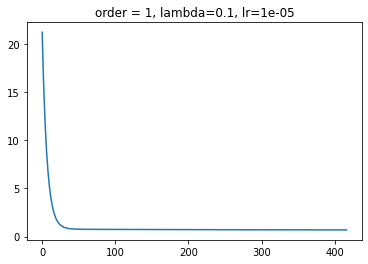

In [21]:
# Let's plot the convergence of MSE values using matplotlib, i.e. #epochs on X-axis and MSE values on Y-axis
# TODO: implement
fig, axes = plt.subplots()

axes.plot(list(train_params_results[order_best][lambda_best][lr_best]['loss'].keys()), list(train_params_results[order_best][lambda_best][lr_best]['loss'].values()))
axes.set_title('order = {}, lambda={}, lr={}'.format(order_best, lambda_best, lr_best))

---
**Points:** $0.0$ of $0.25$

**Comments:** None

---

#### 4.3.10. Evaluation on Test set
**Task 15:** 0.25 points <br >
Evaluate your model on the test data.

In [19]:
# test your model on X_test with the weight vector that you found above
# this will be the generalization error of our model.

X_test = test_data[:, :-1]
Y_test = test_data[:, -1:]
w_best  = train_params_results[order_best][lambda_best][lr_best]['w']

X_test_order, _ = prepare_data_matrix(X_test, w_best, order_best)
preds = get_prediction(X_test_order.float(), w_best.float())
test_mse = compute_mse(preds, Y_test)
print(test_mse)

# TODO: implement

tensor(0.4883, dtype=torch.float64)


---
**Points:** $0.0$ of $0.25$

**Comments:** None

---

#### 4.3.11. Results
**Task 16:** 0.25 points <br >
Report the MSE value on the test data. Which hyperparameter combination turned out to be the best? In your understanding, why do you think such a combination turned out to be the best for this task?

Answer: The MSE value on the test data is found to be 0.4883 with the order of 1 and corresponding lambda and learning rate are 0.1 and 1e-05 respectively. 

The learning rate of lr=1e-5 is already very small and going below this value will make the convergence almost negligible. Similar is the case for lambda where 0.1 is already high enough, increasing this value further would again make the convergence almost negligible.

As for linear regression fitting the dataset better than the higher order polynomial regression, probably the dataset has a few outliers and higher order polynomial regression is massively effected by such outliers.

---
**Points:** $0.0$ of $0.25$

**Comments:** None

---

## Submission instructions
You should provide a single Jupyter notebook (.ipynb file) as the solution. Write the names and student ids of your team members below. **Make sure to submit only 1 solution to only 1 tutor.** Also, follow the naming conventions mentioned in the assignment sheet for naming the jupyter notebook.

- Harsh Agarwal, 7024725
- Zurana Mehrin Ruhi, 7023892

---

## Points: 0.0 of 8.0 points